<a href="https://colab.research.google.com/github/Stevenpach10/ML/blob/main/Proyectos/Proyecto%20III/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [15]:

#MISC
import numpy as np
import logging

#Imaging
from PIL import Image
from matplotlib import pyplot as plt

#System 
import os
import sys
from os.path import splitext
from os import listdir
from glob import glob

#Progress bar
from tqdm import tqdm

# Torch
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.autograd import Function
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder


# Parts

In [16]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        #Layer
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        #Output
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [17]:
#Class to apply the Maxpooling and reducing the dimensionality
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        #Layer
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
        #Output. Apply convolution
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [18]:
#Class to apply upsample and increasing the dim.
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [19]:
#Output class
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Model

In [20]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(self.n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, self.n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Dice_loss

In [21]:
#Better Loss than others for boundaries decision
class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

# Data set 

In [22]:
#Load the dataset.
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
        
        #Limit the size to 256 to avoid dimensions errors
        if img.size != 256:
            img = img.resize((256,256))
        
        if img.size != 256:
            mask = mask.resize((256,256))

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }



# Eval

In [23]:
def eval_net(net, loader, device, criterion):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    mask_type =  torch.long
    n_val = len(loader)  # the number of batch
    tot = 0

    with tqdm(total=n_val, desc='Validation round', unit='batch', leave=False) as pbar:
        for batch in loader:
            imgs, true_masks = batch['image'], batch['mask']
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device,dtype=torch.float32)

            with torch.no_grad():
                mask_pred = net(imgs)

            mask_pred = mask_pred.to(device=device,dtype=torch.float32)
            #Add this according to the issue #218  
            true_masks = true_masks[:,0, :,:].unsqueeze(1)
            
            tot += criterion(mask_pred, true_masks).item()
            pbar.update()

    net.train()
    return tot / (n_val +0.000000000001)

# Train

In [24]:
# Input size of the model.
inputSize = 'inputSize'
# Output size of the model.
outputSize = 'outputSize'
# Batch size.
batchSize = 'batchSize'
# Epochs amount.
epochs = 'epochs'
# Learning rate.
learningRate = 'learningRate'
# Examples to be showed when requested.
testView = 'testView'
# Class names.
classes = 'classes'
# Number of classes to classify.
classesLen = 'classesLen'

config = {
    inputSize    : 224,
    outputSize   : 4,
    batchSize    : 100,
    epochs       : 50,
    learningRate : 0.001,
    classesLen   : 1
}

In [25]:
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5,
              train_loader=None,
              val_loader=None):


    #writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        print("Cross Entropy Loss")
        criterion = nn.CrossEntropyLoss()
    else:
        
        print("BCE")
        criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)


                masks_pred = net(imgs)

                #Add this according to the issue #218  
                true_masks = true_masks[:,0, :,:].unsqueeze(1)


                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                #writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1

        eval_net(net, val_loader, device, criterion)
        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    #writer.close()

# Parameters

In [26]:
dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'

description='Train the UNet on images and target masks'
epochs=25
batchSize=5
learningRate=0.0001
load=False
scale=0.5
validation=10.0

# Model

In [27]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
#   - For 1 class and background, use n_classes=1
#   - For 2 classes, use n_classes=1
#   - For N > 2 classes, use n_classes=N
net = UNet(n_channels=3, n_classes=1, bilinear=True)
logging.info(f'Network:\n'
              f'\t{net.n_channels} input channels\n'
              f'\t{net.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

if load:
    net.load_state_dict(
        torch.load(args.load, map_location=device)
    )
    logging.info(f'Model loaded from {args.load}')

net.to(device=device)

INFO: Using device cpu
INFO: Network:
	3 input channels
	1 output channels (classes)
	Bilinear upscaling


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [14]:
# faster convolutions, but more memory
# cudnn.benchmark = True
dataset = BasicDataset(dir_img, dir_mask, scale)
n_val = int(len(dataset) * validation / 100)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val, batch_size=batchSize, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

try:
    train_net(net=net,
              epochs=epochs,
              batch_size=batchSize,
              lr=learningRate,
              device=device,
              img_scale=scale,
              val_percent=validation / 100,
              train_loader = train_loader,
              val_loader = val_loader)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

INFO: Creating dataset with 301 examples
INFO: Starting training:
        Epochs:          25
        Batch size:      5
        Learning rate:   0.0001
        Training size:   271
        Validation size: 30
        Checkpoints:     True
        Device:          cpu
        Images scaling:  0.5
    
Epoch 1/25: 100%|██████████| 271/271 [01:19<00:00,  3.41img/s, loss (batch)=0.659]


ValueError: Target size (torch.Size([5, 3, 128, 128])) must be the same as input size (torch.Size([5, 1, 128, 128]))

In [21]:
def showImage(image):
    plt.imshow(image[0].squeeze().permute(1,2,0))
    plt.show()

INFO: Creating dataset with 22 examples
Arr


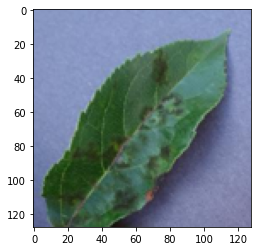

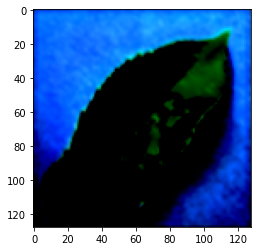

Painting


In [27]:
dataset = BasicDataset(dir_img, dir_mask, scale)
n_val = int(len(dataset) * validation / 100)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val, batch_size=batchSize, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

net.eval()
with torch.no_grad():
    print("Arr")
    for batch in val_loader:
        imgs = batch['image']
        true_masks = batch['mask']

        showImage(true_masks)
        mask_pred = net(imgs)
        showImage(mask_pred)
        print("Painting")
        break